In [1]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance
from scipy.stats import mannwhitneyu, wilcoxon

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [3]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        num_docs = len(c.documents)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, POSITIONS_MAP[c.subject.position], num_docs)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position', 'num_docs'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [168]:
unfiltered_df = df
del df

In [290]:
# relevant_topics_cols = ['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']
relevant_topics_cols = unfiltered_df.columns[:-1].tolist()

relevant_topics_cols

['Topic 1 - Emissions/Gas',
 'Topic 2 - Energy/Cliamate/Oil/Gas',
 'Topic 3 - Forecast',
 'Topic 4 - Forecast',
 'Topic 5 - Forecast/Strom']

In [282]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

In [311]:
# data_df = unfiltered_df[index_filter(unfiltered_df, type='intra-subject')] \
#         .loc[:, relevant_topics_cols] \
#         .sum(axis=1) \
#         .reset_index(drop=False, name='Topic Relevance')

# data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
# data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

# data_df = data_df[data_df['Position'] == 'Meteorologist']

# no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

# data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

# data_df = data_df[data_df.group_y].drop('group_y', axis=1)

# # ---

# num_docs_y = data_df.groupby(['subject_id', 'event_id'])['Topic Relevance'].sum().sort_values()

# num_docs_x = list(range(1, len(num_docs_y) + 1))

# sns.lineplot(x=num_docs_x, y=num_docs_y)

# num_docs_y = num_docs_y[num_docs_y > num_docs_y.quantile(0.8)]
# print(len(num_docs_y))
# sns.lineplot(x=num_docs_x[:len(num_docs_y)], y=num_docs_y)

# plt.show()

# num_docs_y_df = num_docs_y.index.to_frame().reset_index(drop=True)

# num_docs_y_df['filter'] = True

# filter_idx = np.where(unfiltered_df.index.to_frame()[['subject_id', 'event_id']] \
#     .reset_index(drop=True) \
#     .merge(num_docs_y_df, how='left', on=['subject_id', 'event_id'])['filter'] \
#     .fillna(False))

# filtered_df = unfiltered_df.iloc[filter_idx]

filtered_df = unfiltered_df

Event Type:  Join
Number of subjects:  732
w:  51568.0 , P-value:  4.347440023016305e-12 Reject null hypothesis
Average relevance probability (Before event) 0.31167650129131896
Average relevance probability (After event) 0.41080193395727
Increment:  31.80%

Event Type:  Workshop
Number of subjects:  24
w:  73.0 , P-value:  0.23015077818970942 Accept null hypothesis
Average relevance probability (Before event) 0.37393287119062
Average relevance probability (After event) 0.4703993485088777
Increment:  25.80%

Event Type: All
Number of subjects:  738
w:  55455.0 , P-value:  3.432005685263213e-12 Reject null hypothesis
Average relevance probability (Before event) 0.3136476792300831
Average relevance probability (After event) 0.41268892333621277
Increment:  31.58%


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


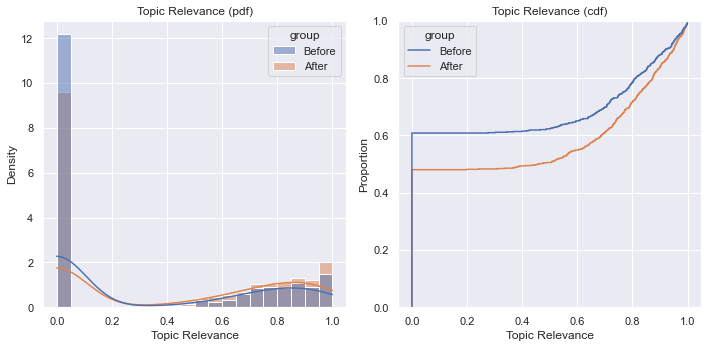

In [315]:
data_df = filtered_df[index_filter(filtered_df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

for event_type in data_df['Event Type'].unique():
    print('Event Type: ', event_type)
    event_df = data_df[data_df['Event Type'] == event_type]
    before_df = event_df[event_df['group'] == 'Before'].set_index(['subject_id', 'event_id'])
    num_subjects = len(before_df.index.get_level_values('subject_id').unique())
    before_s = before_df['Topic Relevance']
    after_df = event_df[event_df['group'] == 'After'].set_index(['subject_id', 'event_id'])
    after_df = after_df.loc[before_df.index, :]
    after_s = after_df['Topic Relevance']
    w, p = wilcoxon(after_s, before_s, alternative='greater')
    print('Number of subjects: ', num_subjects)
    print('w: ', w, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
    # U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
    # print('U:', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
    bm, am = before_s.mean(), after_s.mean()
    print('Average relevance probability (Before event)', bm)
    print('Average relevance probability (After event)', am)
    print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))
    print()

print('Event Type: All')
before_df = data_df[data_df['group'] == 'Before'].set_index(['subject_id', 'event_id'])
before_s = before_df['Topic Relevance']
num_subjects = len(before_df.index.get_level_values('subject_id').unique())
after_df = data_df[data_df['group'] == 'After'].set_index(['subject_id', 'event_id'])
after_df = after_df.loc[before_df.index, :]
after_s = after_df['Topic Relevance']
w, p = wilcoxon(after_s, before_s, alternative='greater')
print('Number of subjects: ', num_subjects)
print('w: ', w, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
bm, am = before_s.mean(), after_s.mean()
print('Average relevance probability (Before event)', bm)
print('Average relevance probability (After event)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

# data_df['Log Topic Relevance'] = np.log(data_df['Topic Relevance'])

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(10, 5)

ax = axs[0]
sns.histplot(data_df, x='Topic Relevance', bins=20, hue='group', stat='density', kde=True, common_norm=False, ax=ax)
ax.set_title('Topic Relevance (pdf)')

ax = sns.ecdfplot(data=data_df, x='Topic Relevance', hue='group', ax=axs[1])
ax.set_title('Topic Relevance (cdf)')

fig.tight_layout()
plt.savefig('intra-subject-topic-relevance-topic-1-5.png', bbox_inches='tight')

In [288]:
# data_df = unfiltered_df[index_filter(unfiltered_df, type='intra-subject-consistency')] \
#         .loc[:, relevant_topics_cols] \
#         .sum(axis=1) \
#         .reset_index(drop=False, name='Topic Relevance')

# data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
# data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

# data_df = data_df[data_df['Position'] == 'Meteorologist']

# # ---

# num_docs_y = data_df.groupby(['subject_id', 'event_id'])['Topic Relevance'].sum().sort_values()

# num_docs_x = list(range(1, len(num_docs_y) + 1))

# sns.lineplot(x=num_docs_x, y=num_docs_y)

# num_docs_y = num_docs_y[num_docs_y > num_docs_y.quantile(0.8)]
# print(len(num_docs_y))
# sns.lineplot(x=num_docs_x[:len(num_docs_y)], y=num_docs_y)

# plt.show()

# num_docs_y_df = num_docs_y.index.to_frame().reset_index(drop=True)

# num_docs_y_df['filter'] = True

# filter_idx = np.where(unfiltered_df.index.to_frame()[['subject_id', 'event_id']] \
#     .reset_index(drop=True) \
#     .merge(num_docs_y_df, how='left', on=['subject_id', 'event_id'])['filter'] \
#     .fillna(False))

# filtered_df = unfiltered_df.iloc[filter_idx]
filtered_df = unfiltered_df

U:  325876.5 , P-value:  3.8198236357165246e-07 Reject null hypothesis
Average consistency (Before event) 2.568388372488173
Average consistency (After event) 2.6640166715905735
Increment:  3.72%


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


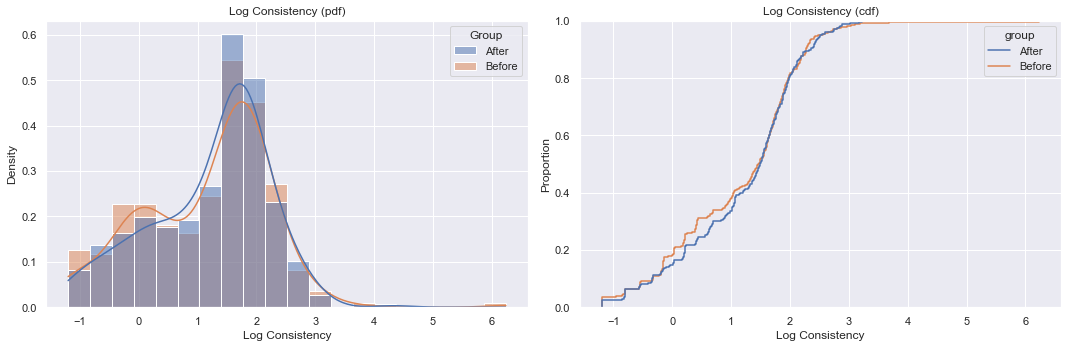

In [317]:
data_df = filtered_df[index_filter(filtered_df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

# data_df = data_df[data_df.std(axis=1) > 0]
consistency_df = data_df.mean(axis=1) / data_df.std(axis=1) 
consistency_df = consistency_df.fillna(0.0)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']
sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

after_s = sub_fig_df[sub_fig_df['Group']=='After']['Consistency']
before_s = sub_fig_df[sub_fig_df['Group']=='Before']['Consistency']

U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
print('U: ', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')

bm, am = before_s.mean(), after_s.mean()
print('Average consistency (Before event)', bm)
print('Average consistency (After event)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ax = axs[0]

sub_fig_df['Log Consistency'] = np.log(sub_fig_df['Consistency'])

sns.histplot(sub_fig_df, x='Log Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=ax,
                hue_order=['After', 'Before'])
# ax.axvline(x=after_s.mean(), color='blue', ls='--', lw=2.5)
# ax.axvline(x=before_s.mean(), color='orange', ls='--', lw=2.5)
ax.set_title('Log Consistency (pdf)')

ax = sns.ecdfplot(data=sub_fig_df, x='Log Consistency', hue='group', ax=axs[1], hue_order=['After', 'Before'])
ax.set_title('Log Consistency (cdf)')

fig.tight_layout()
plt.savefig('intra-subject-log-consistency-topic-1-5.png', bbox_inches='tight')

In [291]:
from src.corpus.keywords import keywords

In [293]:
topic2id = {topic: i for i, topic in enumerate(keywords)}

topic2id

{'causes': 0, 'problem': 1, 'solution': 2, 'description': 3, 'analysis': 4}

In [318]:
for x, y in keywords.items():
    print(topic2id[x], '|', x, '|', ', '.join(y))

0 | causes | chlorofluorocarbons, nitrous oxides, carbon dioxide emissions, hydrochlorofluorocarbons, aerosol, power plant, aerosols, perfluorocarbons, mauna loa, 400ppm, halocarbon, coal fired power plants, power plants, heat-trapping gases, fracking, climate denier, chlorofluorocarbon, climate skeptic, gas, carbon footprint, nitrous oxide, nmvocs, anthropogenic climate change, enhanced greenhouse effect, black carbon, coal, parts per million, greenhouse gases, hfc, halocarbons, keeling curve, fossil fuel, 400 ppm, coal power plants, carbon dioxide, natural gas, hydrochlorofluorocarbon, fossil fuels, nitrogen oxide, hydrofluorocarbon, co2 emissions, hfcs, fluorinated gases, heat trapping gas, greenhouse effect, coal fired power plant, climate sceptic, carbon dioxides, co2, coalbed methane, greenhouse gas, coal-fired power plant, fluorocarbons, heat-trapping gas, perfluorocarbon, methane, nmvoc, hcfcs, hydrofluorocarbons, hydraulic fracturing, coal-fired power plants, emission, carbon 